In [389]:
from matplotlib.pyplot import plot
import numpy as np

#Parámetros que se pueden configurar:
Am = 1          #Amplitud máxima de la moduladora
Wx = 1e3        #Ancho de banda de la moduladora
Ap = 2          #Amplitud de la portadora
fp = 10e3       #Frecuencia de la portadora
m = 0.75        #Índice de modulación
fOL = fp        #Frecuencia del oscilador local (det. síncrono)
phiOL = 0       #Fase del oscilador local (det. síncrono)
moduladora=2    #1: Tono puro, 2: Señal aleatoria




In [390]:
##############################
#Unos cuantos cálculos previos
##############################

#Frecuencia de muestreo. La fijo a 10 veces la de la portadora para tener margen.
fs = 10*fp
#Duración de la señal moduladora
T = 6/Wx
#Genero el vector de tiempos
t = np.arange(0,T,1/fs)

#Filtro paso bajo
#Se filtra paso bajo la señal 'x' con una frecuencia de corte 'cutoff' utilizando un filtro Butterworth de orden 'order'.
from scipy.signal import butter
def filtro_paso_bajo(x, cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    y = lfilter(b, a, x)
    return y

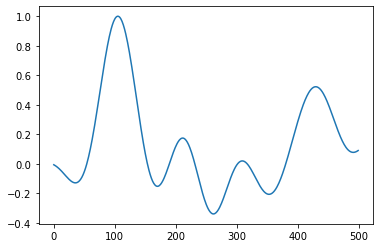

In [391]:
#Generamos la señal moduladora en función de lo seleccionado arriba
if moduladora==1:   #Tono puro de frecuencia Wx
    x = Am*np.cos(2*np.pi*Wx*t)
elif moduladora==2: #Señal aleatoria con ancho de banda Wx
    from numpy.random import default_rng
    rng = default_rng(1234)
    x = rng.standard_normal(t.size)
    x = filtro_paso_bajo(x, Wx, fs, 10)
    x = Am*x/np.max(np.abs(x))

#Represento la señal. 
#Voy a descartar siempre las primeras muestras para evitar el efecto de la carga de los filtros. 
plot(x[int(fs/Wx):])

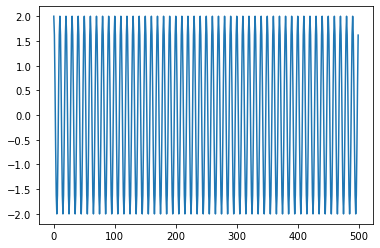

In [392]:
#Generamos la portadora
p = Ap*np.cos(2*np.pi*fp*t)
plot(p[int(fs/Wx):])


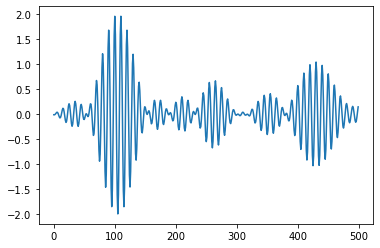

In [393]:
#Señal DBL
xDBL = x*p
plot(xDBL[int(fs/Wx):])

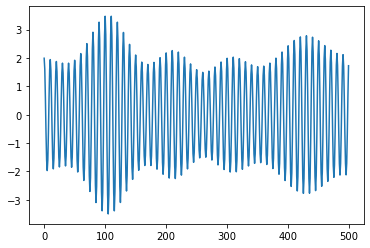

In [394]:
#Señal AM
xAM = (1+m*x/Am)*p
plot(xAM[int(fs/Wx):])

In [395]:
##########################################
#Funciones para implementar los detectores
##########################################

#Detector síncrono
def detector_sincrono(xR, fm, fs, fOL, phiOL, t):
    OL = 2*np.cos(2*np.pi*fOL*t + phiOL)
    x1 = xR*OL
    y = filtro_paso_bajo(x1, fm, fs, 3) 
    y = y - np.mean(y)   
    return y

#Detector de envolvente
from scipy.signal import hilbert
def detector_envolvente(xR, fm, fs):
    env = np.absolute(hilbert(xR))
    y = filtro_paso_bajo(env, fm, fs, 3)   
    y = y - np.mean(y) 
    return y

    



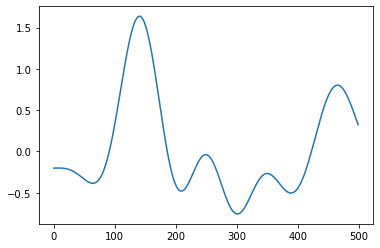

In [396]:
#Utilizo un detector síncrono para la señal DBL
y = detector_sincrono(xDBL, Wx, fs, fOL, phiOL, t)
plot(y[int(fs/Wx):])


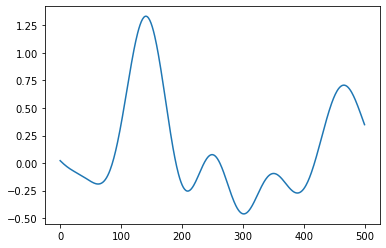

In [397]:
#Y ahora un detector de envolvente para la AM
y = detector_envolvente(xAM, Wx, fs)
plot(y[int(fs/Wx):])